### Using Callbacks

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 75
img_rows, img_cols = 32,32
batch_size = 16

train_data_dir = './fruits-360/Training'
test_data_dir = './fruits-360/Test'

/home/ekele/.conda/envs/gpudeeplearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Data Augmentation

In [2]:
?ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(img_rows, img_cols),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_generator = validation_datagen.flow_from_directory(test_data_dir,
                                                             target_size=(img_rows, img_cols),
                                                             batch_size=batch_size,
                                                             class_mode='categorical',
                                                             shuffle=False)

Found 37836 images belonging to 75 classes.
Found 12709 images belonging to 75 classes.


#### Model Definition

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                input_shape=(img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [5]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("TrainedModel/weights-fruit360-{epoch:02d}-{val_acc:.2f}.hdf5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 37836
nb_validation_samples = 12709
epochs = 10

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples // batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
2364/2364 [==============================] - 592s 250ms/step - loss: 1.6676 - acc: 0.4967 - val_loss: 0.5223 - val_acc: 0.8223

Epoch 00001: val_loss improved from inf to 0.52232, saving model to TrainedModel/weights-fruit360-01-0.82.hdf5
Epoch 2/10
2364/2364 [==============================] - 38s 16ms/step - loss: 0.5585 - acc: 0.8216 - val_loss: 0.3766 - val_acc: 0.8875

Epoch 00002: val_loss improved from 0.52232 to 0.37663, saving model to TrainedModel/weights-fruit360-02-0.89.hdf5
Epoch 3/10
2364/2364 [==============================] - 36s 15ms/step - loss: 0.4386 - acc: 0.8705 - val_loss: 0.2267 - val_acc: 0.9223

Epoch 00003: val_loss improved from 0.37663 to 0.22667, saving model to TrainedModel/weights-fruit360-03-0.92.hdf5
Epoch 4/10
2364/2364 [==============================] - 34s 15ms/step - loss: 0.4206 - acc: 0.8825 - val_loss: 0.1625 - val_acc: 0.9521

Epoch 00004: val_loss improved from 0.22667 to 0.16252, saving model to TrainedModel/weights-fruit360-04-0.95

In [10]:
score = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size+1)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 1.0256716439265143
Test accuracy 0.8028955858053348


#### Displaying Confusion Matrix

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[103   0   0 ...   0   0   0]
 [  0 162   0 ...   0   0   0]
 [  0   0 102 ...   0   0   0]
 ...
 [  0   0   0 ... 148   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 126]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.36      0.63      0.45       164
     Apple Golden 1       0.96      0.99      0.98       164
     Apple Golden 2       0.93      0.62      0.74       164
     Apple Golden 3       0.00      0.00      0.00       161
 Apple Granny Smith       0.84      0.91      0.88       164
        Apple Red 1       0.98      0.97      0.98       164
        Apple Red 2       1.00      0.04      0.08       164
        Apple Red 3       1.00      0.38      0.55       144
Apple Red Delicious       0.94      1.00      0.97       166
   Apple Red Yellow       0.94      1.00      0.97       164
            Apricot       0.51      1.00      0.68       164
            Avocado       1.00      

/home/ekele/.conda/envs/gpudeeplearning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


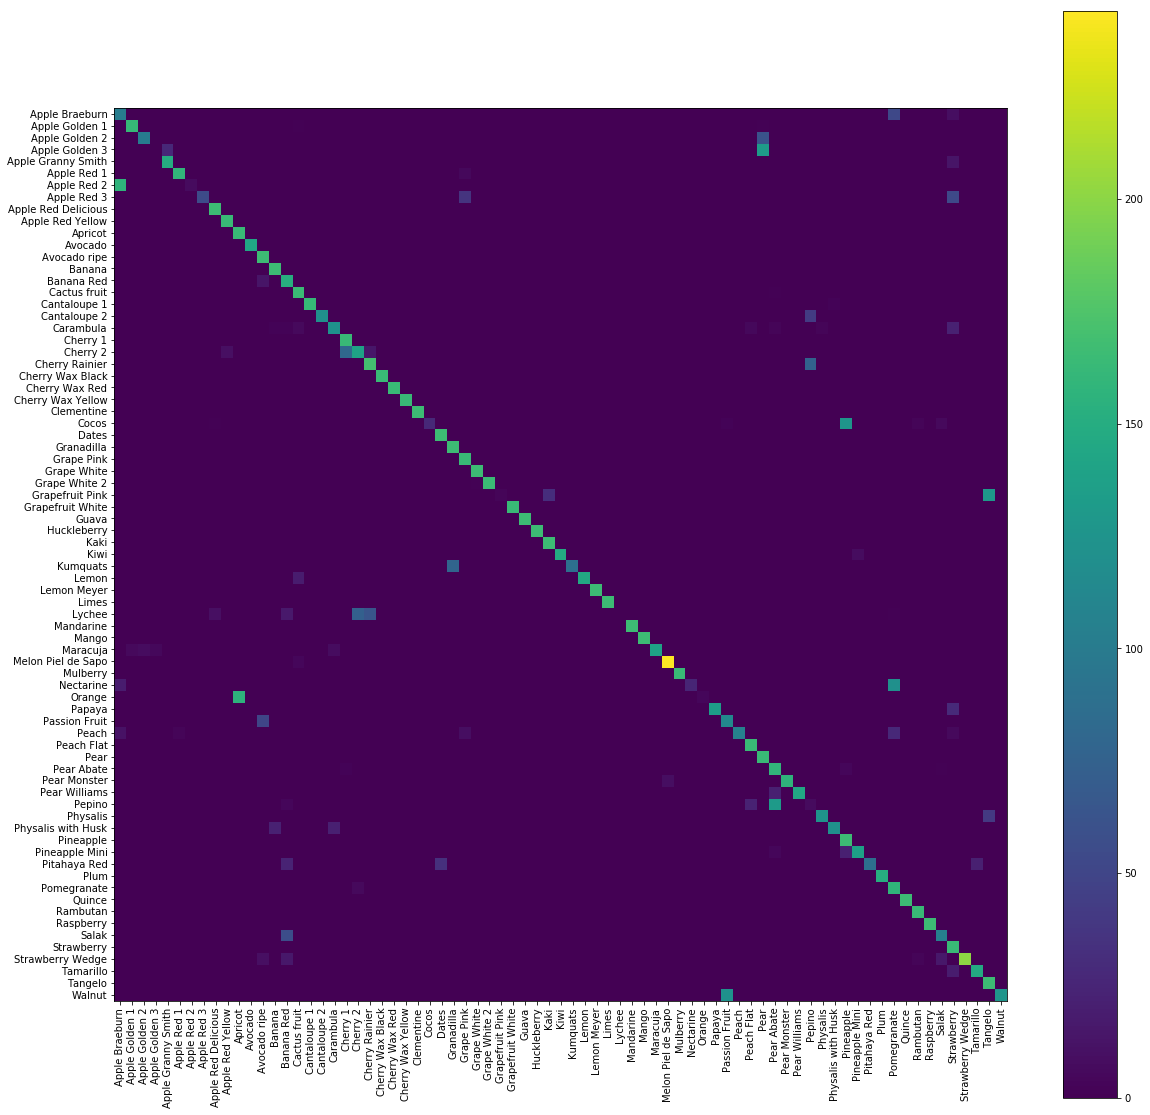

In [11]:
import matplotlib.pyplot as plt
import sklearn
from keras.models import load_model

img_row, img_cols, img_channels = 32,32,3
model = load_model('TrainedModel/weights-fruit360-05-0.96.hdf5')
classes = list(class_labels.values())

nb_train_samples = 37836
nb_validation_samples = 12709

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [14]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './fruits-360/Test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()